In [369]:
## CODE1p (CONSTANT)
!pip3 install numpy jax cvxpy matplotlib



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [370]:
## CODE2p (CONSTANT)
import numpy as np
import jax
import jax.numpy as jnp
import cvxpy as cp
import matplotlib.pyplot as plt

In [371]:
## CODE3p (VARIABLE)
class DoubleInt: # this is where the euler approximation of the state is computed. 
    ndim = 4 # (VARIABLE)
    control_dim = 2     # (VARIABLE)
    def __init__(self):
        self.umin = np.array([-1.0, 5.0])  # (VARIABLE)
        self.umax = np.array([1.0, 14.0])    # (VARIABLE)
        self.dt = 0.01  # Time step    
    
    def step(self, state, control):
        print("Control dimensions inside step:", control.shape)
        return state + self.dt * self(state, control)
        print("State dimensions after dynamics computation (step):", result.shape)
    
    def __call__(self, state, control):
        print("State dimensions in __call__:", state.shape)
        print("Control dimensions in __call__:", control.shape)
        result = self.open_loop_dynamics(state) + self.control_jacobian(state) @ control  # (VARIABLE)
        print("Resulting dimensions in __call__:", result.shape)
        return result

    def open_loop_dynamics(self, state):
        out = np.zeros_like(state)
        out[..., 0] = state[..., 2]  # (VARIABLE)
        out[..., 1] = state[..., 3]  # (VARIABLE)
        out[..., 3] = -9.81
        print("Open-loop dynamics output dimensions:", out.shape)
        return out

    def control_jacobian(self, state):
        out = np.zeros((*state.shape[:-1], self.ndim, self.control_dim))
        out[..., 2, 0] = 9.81  # (VARIABLE) Roll affects y_dot 
        out[..., 3, 1] = 1.0  # (VARIABLE) Thrust affects z_dot
        print("Control Jacobian shape:", out.shape)
        return out

In [372]:
## CODE4p (UPDATED)
class SimpleCBF:  # Safety function is defined here
    def __init__(self, dynamics):
        self.dynamics = dynamics
    
    def vf(self, state):
        state = jnp.array(state)
        # Circular safety boundary
        circle_constraint = 5 - jnp.sqrt(state[0]**2 + state[1]**2)
        # Square boundary constraints
        square_constraint_y = 5 - jnp.abs(state[0])  # y-bound
        square_constraint_z = 5 - jnp.abs(state[1])  # z-bound
        # Combine both constraints
        return jnp.minimum(circle_constraint, jnp.minimum(square_constraint_y, square_constraint_z))
    
    def grad_vf(self, state):
        state = jnp.array(state)
        # Check for near-zero norm to avoid numerical issues
        if np.isclose(state[0]**2 + state[1]**2, 0.0):
            return jnp.zeros(4)
        return jax.grad(self.vf)(state)


class ExtendedCBF(SimpleCBF):  # Extends the safety function to include velocity
    def vf(self, state):
        scaling_factor = 0.72
        state = jnp.array(state)
        # Circular safety boundary with velocity
        circle_constraint = 5 - scaling_factor*(jnp.sqrt(state[0]**2 + state[1]**2)) - scaling_factor*(jnp.sqrt(state[2]**2 + state[3]**2))
        # Square boundary constraints
        square_constraint_y = 5 - jnp.abs(state[0])  # y-bound
        square_constraint_z = 5 - jnp.abs(state[1])  # z-bound
        # Combine both constraints
        return jnp.minimum(circle_constraint, jnp.minimum(square_constraint_y, square_constraint_z))


In [373]:
## CODE5p (CONSTANT)
class SafetyFilter:
    def __init__(self, cbf):
        self.cbf = cbf
        self.dynamics = self.cbf.dynamics
        self.gamma = 0.6  # Even gentler gamma for smoother approach to wall
        
    def __call__(self, state, nominal_control):
        vf = self.cbf.vf(state)
        grad_vf = self.cbf.grad_vf(state)
        Lg_v = grad_vf @ self.dynamics.control_jacobian(state)
        Lf_v = grad_vf @ self.dynamics.open_loop_dynamics(state)
        
        u = cp.Variable(nominal_control.shape)
        # Adjust weights to prioritize position convergence
        weights = np.diag([12.0, 1.0])  # Less aggressive on thrust, more on pitchNah wha
        obj = cp.Minimize(cp.quad_form(u - nominal_control, weights))
        constraints = [Lf_v + Lg_v @ u >= -self.gamma * vf]
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3)
        if u.value is not None:
            return u.value, True
        else:
            return nominal_control, False

In [374]:
## CODE6p (CONSTANT)
## This is where we call on the previously defined classes to initialize
dynamics = DoubleInt()
cbf = SimpleCBF(dynamics)
safety_filter = SafetyFilter(cbf)

In [375]:
## CODE7p (VARIABLE)
## This is where we use the tager goal with the safety function, a velocity damping, and a clipping funciton 
## to ensure velocity doesn't exceed limitation
nominal_control = lambda state: np.clip(
    np.array([
        - 1.0 * (state[0] - 6.0) - 2.0 * state[2],  # Kept original y-target (6.0), adjusted gains
        9.81 - 0.75 * (state[1] - 6.0) - 1.5 * state[3]  # Kept original z-target (6.0), increased damping
    ]),
    dynamics.umin,
    dynamics.umax
)

In [376]:
## CODE8p (CONSTANT)
## It initializes the starting state to be zero with a vector of same size as predetermined state vector. Calibration. 
## Makes sure that code8 and code10 iterates from a proper initial state. 
starting_state = np.zeros((dynamics.ndim))

In [377]:
## CODE9p (CONSTANT)
## BIG PICTURE: 
## 1. Track how state evolves over time under nominal control
## 2. Observe how barrier function value 'vf' changes and ensures the system remains in a "safe" state
## 3. Records the applied controls which is then later compared to filtered controls in code10 
########################################################################################################################

## Initializes the states, safety function, and controls to be filled while also retrieving the initial state from code7 
states = []
vfs = []
controls = []
state = starting_state
control = nominal_control(starting_state)
print("Control dimensions after clipping (nominal_control):", control.shape)
## Repeats for 1000 time steps
for t in range(1000):
    print(f"Iteration {t}")
    print("State dimensions (before dynamics.step):", state.shape)
    ## Stores current state for iteration
    states.append(state)
    ## Computes current control for iteration then appends to predefined array
    control = nominal_control(state)
    print("Control dimensions (before dynamics.step):", control.shape)
    controls.append(control)
    ## Computes safety function for iteration then appends to predefined array
    vf = cbf.vf(state)
    vfs.append(vf)
    ## Updates the state based on system dynamics and controls
    state = dynamics.step(state, control)#.reshape(-1)

## Converts list to arrays 
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Control dimensions after clipping (nominal_control): (2,)
Iteration 0
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Iteration 1
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Iteration 2
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 

Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Iteration 77
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Iteration 78
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Iteration 79
State dimensions (before dynamics.step): (4,)
Control dimensions (before dynamics.step): (2,)
Control dimen

Text(0.5, 0.98, 'Nominal control with combined y-z trajectory and velocity plots')

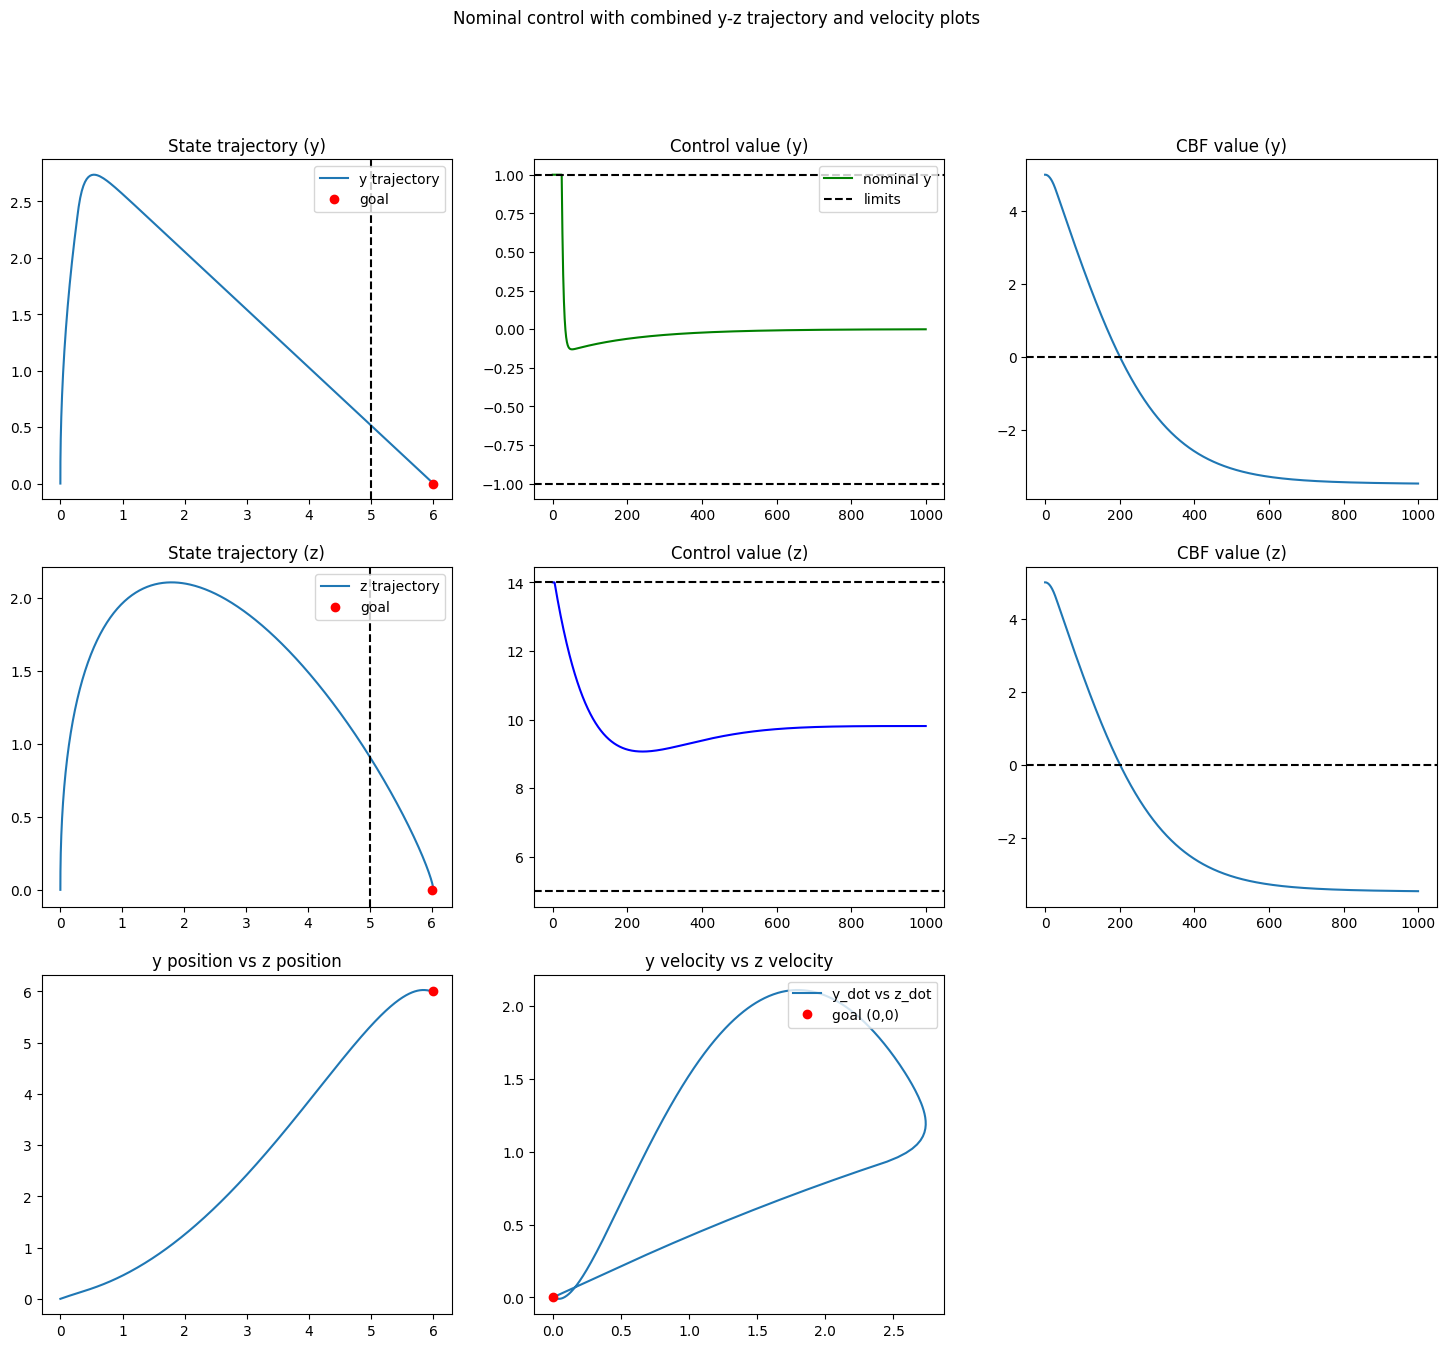

In [378]:
## CODE10p

fig, ax = plt.subplots(3, 3, figsize=(18, 15))

# First row: y-component (latitude)
ax[0, 0].plot(states[:, 0], states[:, 2], label='y trajectory')  # y vs y_dot
ax[0, 0].plot(6, 0, 'ro', label='goal')  # Goal for y-component
ax[0, 0].legend(loc='upper right')
ax[0, 0].set_ylim()
ax[0, 0].vlines(5, ax[0, 0].get_ylim()[0], ax[0, 0].get_ylim()[1], color='k', linestyle="--")
ax[0, 0].set_title("State trajectory (y)")

ax[0, 1].plot(controls[:, 0], color='green', label='nominal y')
ax[0, 1].set_xlim()
ax[0, 1].hlines(dynamics.umin[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0, 1].hlines(dynamics.umax[0], ax[0, 1].get_xlim()[0], ax[0, 1].get_xlim()[1], color='k', linestyle="--")
ax[0, 1].legend(loc='upper right')
ax[0, 1].set_title("Control value (y)")

ax[0, 2].plot(vfs, label='CBF y')  # Assuming vfs includes y component values
ax[0, 2].set_xlim()
ax[0, 2].hlines(0.0, ax[0, 2].get_xlim()[0], ax[0, 2].get_xlim()[1], color='k', linestyle="--")
ax[0, 2].set_title("CBF value (y)")

# Second row: z-component (altitude)
ax[1, 0].plot(states[:, 1], states[:, 3], label='z trajectory')  # z vs z_dot
ax[1, 0].plot(6, 0, 'ro', label='goal')  # Goal for z-component
ax[1, 0].legend(loc='upper right')
ax[1, 0].set_ylim()
ax[1, 0].vlines(5, ax[1, 0].get_ylim()[0], ax[1, 0].get_ylim()[1], color='k', linestyle="--")
ax[1, 0].set_title("State trajectory (z)")

ax[1, 1].plot(controls[:, 1], color='blue', label='nominal z')
ax[1, 1].set_xlim()
ax[1, 1].hlines(dynamics.umin[1], ax[1, 1].get_xlim()[0], ax[1, 1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1, 1].hlines(dynamics.umax[1], ax[1, 1].get_xlim()[0], ax[1, 1].get_xlim()[1], color='k', linestyle="--")
#ax[1, 1].legend(loc='upper right')
ax[1, 1].set_title("Control value (z)")

ax[1, 2].plot(vfs, label='CBF z')  # Assuming vfs includes z component values
ax[1, 2].set_xlim()
ax[1, 2].hlines(0.0, ax[1, 2].get_xlim()[0], ax[1, 2].get_xlim()[1], color='k', linestyle="--")
ax[1, 2].set_title("CBF value (z)")

# Third row: Combined trajectories (y vs z and y_dot vs z_dot)
## y-position vs z-position
ax[2, 0].plot(states[:, 0], states[:, 1], label='y vs z')  # z-position vs y-position
ax[2, 0].plot(6, 6, 'ro', label='goal (6,6)')  # Goal point
#ax[2, 0].legend(loc='upper right')
ax[2, 0].set_title("y position vs z position")

## y-velocity vs z-velocity
ax[2, 1].plot(states[:, 2], states[:, 3], label='y_dot vs z_dot')  # y-velocity vs z-velocity
ax[2, 1].plot(0, 0, 'ro', label='goal (0,0)')  # Goal point
ax[2, 1].legend(loc='upper right')
ax[2, 1].set_title("y velocity vs z velocity")

# Leave (2,2) blank or customize further
ax[2, 2].axis('off')  # Optionally leave the last subplot empty
fig.suptitle("Nominal control with combined y-z trajectory and velocity plots")


In [379]:
## CODE11p
## Essentially same thing as CODE8 but now just filters the nominal control using the "dumb" CBF
states = []
vfs = []
controls = []
qp_feasibles = []
state = starting_state
for t in range(1000):
    states.append(state)
    ## Computes nominal control from code6 and modifies it using the safety filter from code4. 
    ## Then outputs the adjusted control input that satisfies the safety constraints if feasible
    control, qp_feasible = safety_filter(state, nominal_control(state))
    controls.append(control)
    ## A boolean indicates whether the QP solution is feasible or not
    qp_feasibles.append(qp_feasible)
    vf = cbf.vf(state)
    vfs.append(vf)
    state = dynamics.step(state, control)
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
S

Text(0.5, 0.98, 'Nominal control with combined y-z trajectory and velocity plots')

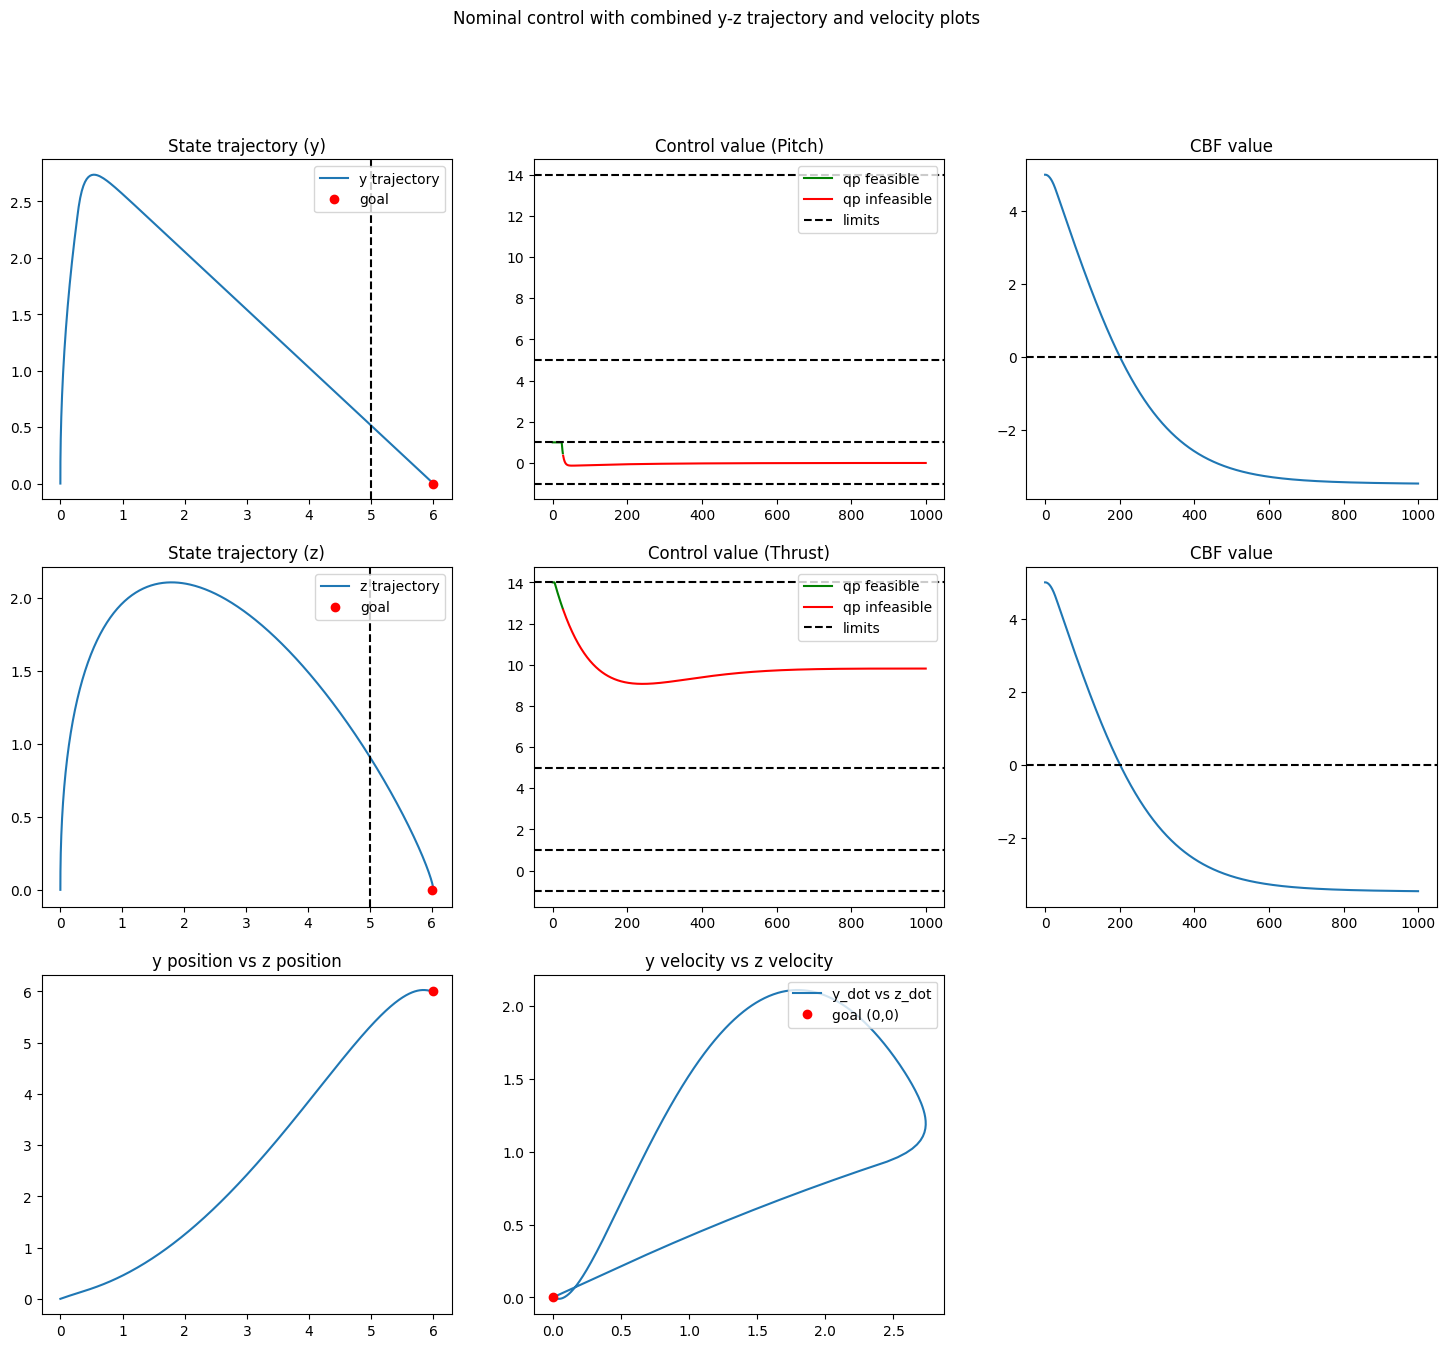

In [380]:
## CODE12p
## Essentially same thing as CODE9 but now with filtered nominal control using the "dumb" CBF 
# print("qp_feasibles:", qp_feasibles)
# print("controls:", controls)
fig, ax = plt.subplots(3, 3, figsize=(18, 15))
ax[0,0].plot(states[:, 0], states[:, 2], label='y trajectory')
ax[0,0].plot(6, 0, 'ro', label='goal')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylim()
# get the min and max of ylim
ax[0,0].vlines(5, ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1], color='k', linestyle="--")
ax[0,0].set_title("State trajectory (y)")
controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,0])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,0])
ax[0,1].plot(controls_feasible, color='green', label='qp feasible')
ax[0,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[0,1].set_xlim()
ax[0,1].hlines(dynamics.umin, ax[0,1].get_xlim()[0], ax[0,1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0,1].hlines(dynamics.umax, ax[0,1].get_xlim()[0], ax[0,1].get_xlim()[1], color='k', linestyle="--")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title("Control value (Pitch)")
ax[0,2].plot(vfs)
ax[0,2].set_xlim()
ax[0,2].hlines(0.0, ax[0,2].get_xlim()[0], ax[0,2].get_xlim()[1], color='k', linestyle="--")
ax[0,2].set_title("CBF value")
fig.suptitle("Invalid CBF")

ax[1,0].plot(states[:, 1], states[:, 3], label='z trajectory')
ax[1,0].plot(6, 0, 'ro', label='goal')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylim()
# get the min and max of ylim
ax[1,0].vlines(5, ax[1,0].get_ylim()[0], ax[1,0].get_ylim()[1], color='k', linestyle="--")
ax[1,0].set_title("State trajectory (z)")
controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,1])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,1])
ax[1,1].plot(controls_feasible, color='green', label='qp feasible')
ax[1,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[1,1].set_xlim()
ax[1,1].hlines(dynamics.umin, ax[1,1].get_xlim()[0], ax[1,1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1,1].hlines(dynamics.umax, ax[1,1].get_xlim()[0], ax[1,1].get_xlim()[1], color='k', linestyle="--")
ax[1,1].legend(loc='upper right')
ax[1,1].set_title("Control value (Thrust)")
ax[1,2].plot(vfs)
ax[1,2].set_xlim()
ax[1,2].hlines(0.0, ax[1,2].get_xlim()[0], ax[1,2].get_xlim()[1], color='k', linestyle="--")
ax[1,2].set_title("CBF value")
fig.suptitle("Invalid CBF")

# Third row: Combined trajectories (y vs z and y_dot vs z_dot)
## y-position vs z-position
ax[2, 0].plot(states[:, 0], states[:, 1], label='y vs z')  # z-position vs y-position
ax[2, 0].plot(6, 6, 'ro', label='goal (6,6)')  # Goal point
#ax[2, 0].legend(loc='upper right')
ax[2, 0].set_title("y position vs z position")

## y-velocity vs z-velocity
ax[2, 1].plot(states[:, 2], states[:, 3], label='y_dot vs z_dot')  # y-velocity vs z-velocity
ax[2, 1].plot(0, 0, 'ro', label='goal (0,0)')  # Goal point
ax[2, 1].legend(loc='upper right')
ax[2, 1].set_title("y velocity vs z velocity")

# Leave (2,2) blank or customize further
ax[2, 2].axis('off')  # Optionally leave the last subplot empty
fig.suptitle("Nominal control with combined y-z trajectory and velocity plots")

In [381]:
## CODE13p
## Assigns the controls from code10 and stores it for the "dumb" cbf
controls_simple_cbf = controls

In [382]:
## CODE14p
## Initializes for the Smarter CBF 
dynamics = DoubleInt()
cbf = ExtendedCBF(dynamics)
safety_filter = SafetyFilter(cbf)

In [383]:
## CODE15p
## Essentially same thing as CODE8 and COE10 but now just filters the nominal control using the Smart CBF
states = []
vfs = []
controls = []
qp_feasibles = []
state = starting_state
for t in range(1000):
    states.append(state)
    control, qp_feasible = safety_filter(state, nominal_control(state))
    controls.append(control)
    qp_feasibles.append(qp_feasible)
    vf = cbf.vf(state)
    vfs.append(vf)
    state = dynamics.step(state, control)
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
State dimensions in __call__: (4,)
Control dimensions in __call__: (2,)
Open-loop dynamics output dimensions: (4,)
Control Jacobian shape: (4, 2)
Resulting dimensions in __call__: (4,)
Control Jacobian shape: (4, 2)
Open-loop dynamics output dimensions: (4,)
Control dimensions inside step: (2,)
S

Text(0.5, 0.98, 'Nominal control with combined y-z trajectory and velocity plots')

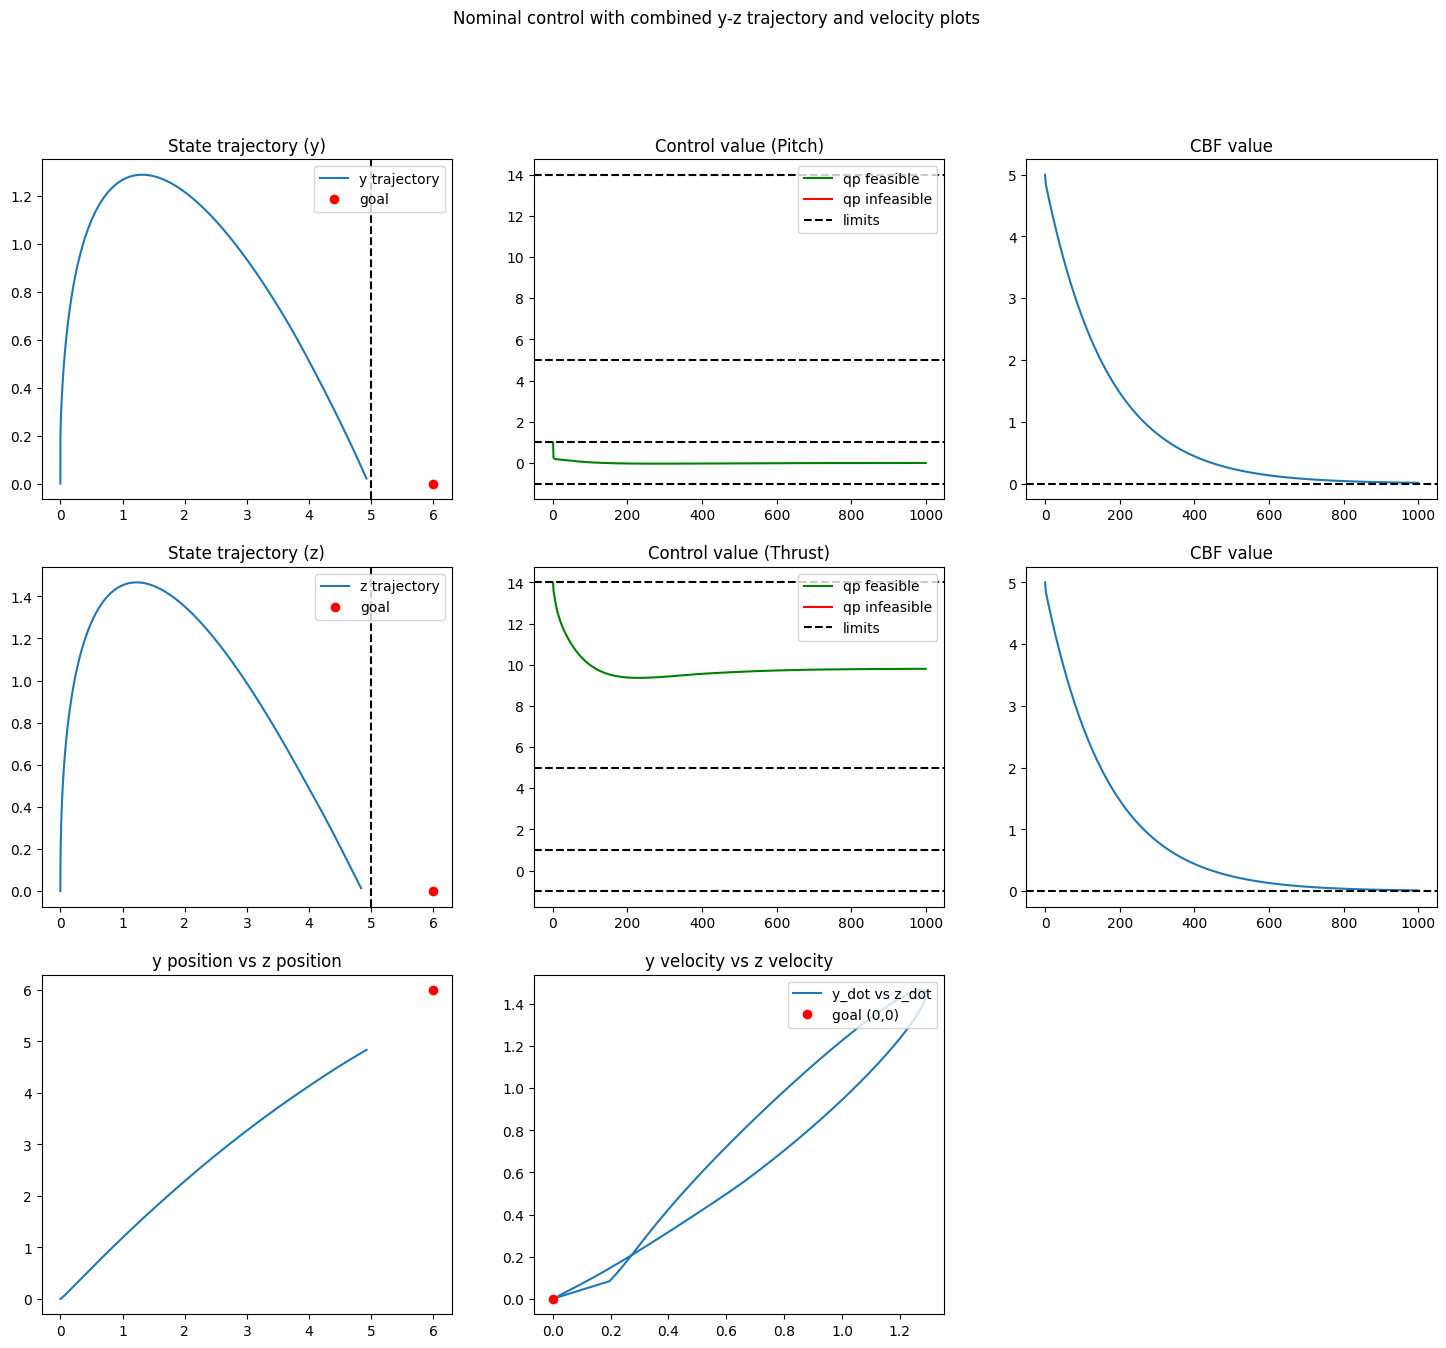

In [384]:
## CODE16p
## Essentially same thing as CODE9 and CODE11 but now with filtered nominal control using the SMART CBF 
fig, ax = plt.subplots(3, 3, figsize=(18, 15))
ax[0,0].plot(states[:, 0], states[:, 2], label='y trajectory')
ax[0,0].plot(6, 0, 'ro', label='goal')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylim()
# get the min and max of ylim
ax[0,0].vlines(5, ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1], color='k', linestyle="--")
ax[0,0].set_title("State trajectory (y)")
controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,0])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,0])
ax[0,1].plot(controls_feasible, color='green', label='qp feasible')
ax[0,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[0,1].set_xlim()
ax[0,1].hlines(dynamics.umin, ax[0,1].get_xlim()[0], ax[0,1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[0,1].hlines(dynamics.umax, ax[0,1].get_xlim()[0], ax[0,1].get_xlim()[1], color='k', linestyle="--")
ax[0,1].legend(loc='upper right')
ax[0,1].set_title("Control value (Pitch)")
ax[0,2].plot(vfs)
ax[0,2].set_xlim()
ax[0,2].hlines(0.0, ax[0,2].get_xlim()[0], ax[0,2].get_xlim()[1], color='k', linestyle="--")
ax[0,2].set_title("CBF value")
fig.suptitle("Invalid CBF")

ax[1,0].plot(states[:, 1], states[:, 3], label='z trajectory')
ax[1,0].plot(6, 0, 'ro', label='goal')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylim()
# get the min and max of ylim
ax[1,0].vlines(5, ax[1,0].get_ylim()[0], ax[1,0].get_ylim()[1], color='k', linestyle="--")
ax[1,0].set_title("State trajectory (z)")
controls_feasible = np.ma.masked_where(~np.array(qp_feasibles), np.array(controls)[:,1])
controls_non_feasible = np.ma.masked_where(np.array(qp_feasibles), np.array(controls)[:,1])
ax[1,1].plot(controls_feasible, color='green', label='qp feasible')
ax[1,1].plot(controls_non_feasible, color='red', label='qp infeasible')
ax[1,1].set_xlim()
ax[1,1].hlines(dynamics.umin, ax[1,1].get_xlim()[0], ax[1,1].get_xlim()[1], color='k', linestyle="--", label='limits')
ax[1,1].hlines(dynamics.umax, ax[1,1].get_xlim()[0], ax[1,1].get_xlim()[1], color='k', linestyle="--")
ax[1,1].legend(loc='upper right')
ax[1,1].set_title("Control value (Thrust)")
ax[1,2].plot(vfs)
ax[1,2].set_xlim()
ax[1,2].hlines(0.0, ax[1,2].get_xlim()[0], ax[1,2].get_xlim()[1], color='k', linestyle="--")
ax[1,2].set_title("CBF value")
fig.suptitle("Invalid CBF")

# Third row: Combined trajectories (y vs z and y_dot vs z_dot)
## y-position vs z-position
ax[2, 0].plot(states[:, 0], states[:, 1], label='y vs z')  # z-position vs y-position
ax[2, 0].plot(6, 6, 'ro', label='goal (6,6)')  # Goal point
#ax[2, 0].legend(loc='upper right')
ax[2, 0].set_title("y position vs z position")

## y-velocity vs z-velocity
ax[2, 1].plot(states[:, 2], states[:, 3], label='y_dot vs z_dot')  # y-velocity vs z-velocity
ax[2, 1].plot(0, 0, 'ro', label='goal (0,0)')  # Goal point
ax[2, 1].legend(loc='upper right')
ax[2, 1].set_title("y velocity vs z velocity")

# Leave (2,2) blank or customize further
ax[2, 2].axis('off')  # Optionally leave the last subplot empty
fig.suptitle("Nominal control with combined y-z trajectory and velocity plots")

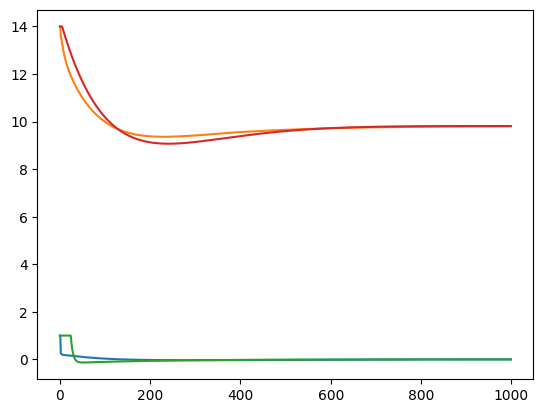

In [385]:
## CODE17p
plt.plot(controls, label='Extended CBF')
plt.plot(controls_simple_cbf, label='Simple CBF')
